## Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '../input/ranzcr-clip-catheter-line-classification/train'

## Data Loading

In [2]:
train = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train.csv')
test = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv')
train_annotations = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train_annotations.csv')

In [3]:
# delete suspicious data
train = train[train['StudyInstanceUID'] != '1.2.826.0.1.3680043.8.498.93345761486297843389996628528592497280'].reset_index(drop=True)
train_annotations = train_annotations[train_annotations['StudyInstanceUID'] != '1.2.826.0.1.3680043.8.498.93345761486297843389996628528592497280'].reset_index(drop=True)

## CFG

In [4]:
##### ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    device='GPU' # ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    print_freq=100
    num_workers=4
    model_name='densenet121'
    size=640
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=5
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=5 # CosineAnnealingLR
    #T_0=4 # CosineAnnealingWarmRestarts
    lr=1e-4 # 1e-4
    min_lr=1e-6
    batch_size=8 # 64
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=416
    target_size=11
    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
                 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                 'Swan Ganz Catheter Present']
    n_fold=5
    trn_fold=[1] # [0, 1, 2, 3, 4]
    train=True
    
if CFG.debug:
    CFG.epochs = 4
    train = train.sample(n=5000, random_state=CFG.seed).reset_index(drop=True)

In [5]:
if CFG.device == 'TPU':
    import os
    os.system('curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py')
    os.system('python pytorch-xla-env-setup.py --version 1.7 --apt-packages libomp5 libopenblas-dev')
    os.system('export XLA_USE_BF16=1')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.batch_size = CFG.batch_size // CFG.nprocs

## Library

In [6]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-images-seresnet')

import os
import ast
import copy
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue, CoarseDropout
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

if CFG.device == 'TPU':
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

## Utils

In [7]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')
    
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

## CV split

In [8]:
folds = train.copy()
Fold = GroupKFold(n_splits=CFG.n_fold)
groups = folds['PatientID'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_cols], groups)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
display(folds.groupby('fold').size())

fold
0    6017
1    6017
2    6016
3    6016
4    6016
dtype: int64

## Dataset

In [9]:
# =======================================================
# Dataset
# =======================================================
COLOR_MAP = {'ETT - Abnormal': (255, 0, 0),
             'ETT - Borderline': (0, 255, 0),
             'ETT - Normal': (0, 0, 255),
             'NGT - Abnormal': (255, 255, 0),
             'NGT - Borderline': (255, 0, 255),
             'NGT - Incompletely Imaged': (0, 255, 255),
             'NGT - Normal': (128, 0, 0),
             'CVC - Abnormal': (0, 128, 0),
             'CVC - Borderline': (0, 0, 128),
             'CVC - Normal': (128, 128, 0),
             'Swan Ganz Catheter Present': (128, 0, 128),
            }

class TrainDataset(Dataset):
    def __init__(self, df, df_annotations, annot_size=50, transform=None):
        self.df = df
        self.df_annotations = df_annotations
        self.annot_size = annot_size
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        query_string = f"StudyInstanceUID == '{file_name}'"
        df = self.df_annotations.query(query_string)
        for i, row in df.iterrows():
            label = row['label']
            data = np.array(ast.literal_eval(row['data']))
            for d in data:
                image[d[1]-self.annot_size//2:d[1]+self.annot_size//2, 
                      d[0]-self.annot_size//2:d[0]+self.annot_size//2, 
                      :] = COLOR_MAP[label]
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

## Transforms

In [10]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            RandomBrightnessContrast(p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
            HueSaturationValue(p=0.2, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            ShiftScaleRotate(p=0.2, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
            CoarseDropout(p=0.2),
            Cutout(p=0.2, max_h_size=16, max_w_size=16, fill_value=(0., 0., 0.), num_holes=16),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

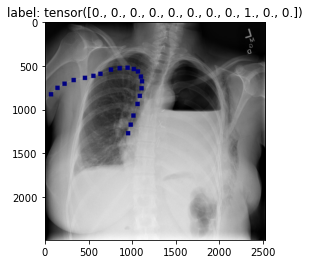

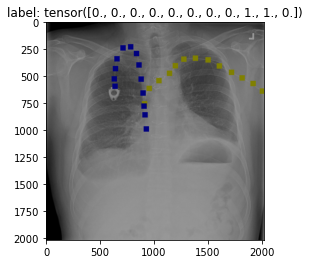

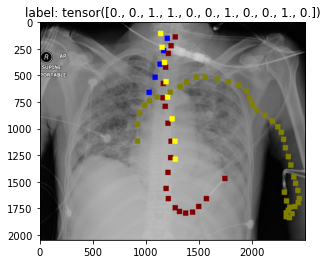

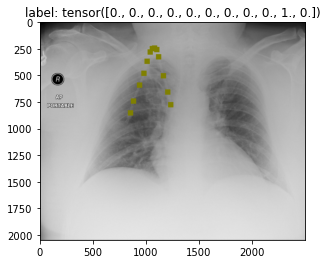

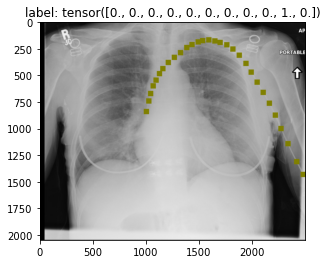

In [11]:
from matplotlib import pyplot as plt

train_dataset = TrainDataset(folds[folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True),
                             train_annotations, transform=None)

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

## MODEL

In [12]:
# ====================================================
# MODEL
# ====================================================
class CustomDenseNet(nn.Module):
    def __init__(self, model_name='tf_efficientnet_b5_ns', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        n_features  = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)
        if pretrained:
            pretrained_path = '../input/startingpointschestx/densenet121_chestx.pth'
#             self.model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cpu'))['model'])
            
            checkpoint = torch.load(pretrained_path, map_location='cpu')['model']
            for key in list(checkpoint.keys()):
                if 'model.' in key:
                    checkpoint[key.replace('model.', '')] = checkpoint[key]
                    del checkpoint[key]
            self.model.load_state_dict(checkpoint) 
            
            print(f'load {model_name} pretrained model')
        n_features = self.model.classifier.in_features
        self.model.global_pool = nn.Identity()
        self.model.classifier = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(n_features, CFG.target_size)
        
    def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        pooled_features = self.pooling(features).view(bs, -1)
        output = self.classifier(pooled_features)
        return features, pooled_features, output

## Helper functions

In [13]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.device == 'GPU':
            with autocast():
                _, _, y_preds = model(images)
                loss = criterion(y_preds, labels)
                # record loss 
                losses.update(loss.item(), batch_size)
                if CFG.gradient_accumulation_steps > 1:
                    loss = loss / CFG.gradient_accumulation_steps
                scaler.scale(loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
                if (step + 1) % CFG.gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    global_step += 1
        elif CFG.device == 'TPU':
            _, _, y_preds = model(images)
            loss = criterion(y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.gradient_accumulation_steps > 1:
                loss = loss / CFG.gradient_accumulation_steps
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.gradient_accumulation_steps == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
                global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      'Grad: {grad_norm:.4f}  '
                      #'LR: {lr:.6f}  '
                      .format(
                       epoch+1, step, len(train_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(train_loader)),
                       grad_norm=grad_norm,
                       #lr=scheduler.get_lr()[0],
                       ))
        elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                xm.master_print('Epoch: [{0}][{1}/{2}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                'Grad: {grad_norm:.4f}  '
                                #'LR: {lr:.6f}  '
                                .format(
                                epoch+1, step, len(train_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(train_loader)),
                                grad_norm=grad_norm,
                                #lr=scheduler.get_lr()[0],
                                ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    trues = []
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            _, _, y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        trues.append(labels.to('cpu').numpy())
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
    if CFG.device == 'GPU':
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
                xm.master_print('EVAL: [{0}/{1}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                .format(
                                step, len(valid_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(valid_loader)),
                                ))
    trues = np.concatenate(trues)
    predictions = np.concatenate(preds)
    return losses.avg, predictions, trues

## Train loop

In [14]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    if CFG.device == 'GPU':
        LOGGER.info(f"========== fold: {fold} training ==========")
    elif CFG.device == 'TPU':
        if CFG.nprocs == 1:
            LOGGER.info(f"========== fold: {fold} training ==========")
        elif CFG.nprocs == 8:
            xm.master_print(f"========== fold: {fold} training ==========")
    
    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    
    train_folds = train_folds[train_folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True)
    valid_folds = valid_folds[valid_folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True)
    
    valid_labels = valid_folds[CFG.target_cols].values

    train_dataset = TrainDataset(train_folds, train_annotations,
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, train_annotations,
                                 transform=get_transforms(data='valid'))
    
    if CFG.device == 'GPU':
        train_loader = DataLoader(train_dataset, 
                                  batch_size=CFG.batch_size, 
                                  shuffle=True, 
                                  num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, 
                                  batch_size=CFG.batch_size * 2, 
                                  shuffle=False, 
                                  num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
        
    
    elif CFG.device == 'TPU':
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset,
                                                                        num_replicas=xm.xrt_world_size(),
                                                                        rank=xm.get_ordinal(),
                                                                        shuffle=True)
        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=CFG.batch_size,
                                                   sampler=train_sampler,
                                                   drop_last=True,
                                                   num_workers=CFG.num_workers)
        
        valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_dataset,
                                                                        num_replicas=xm.xrt_world_size(),
                                                                        rank=xm.get_ordinal(),
                                                                        shuffle=False)
        valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                   batch_size=CFG.batch_size * 2,
                                                   sampler=valid_sampler,
                                                   drop_last=False,
                                                   num_workers=CFG.num_workers)
        
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler
    
    # ====================================================
    # model & optimizer
    # ====================================================
    if CFG.device == 'TPU':
        device = xm.xla_device()
    elif CFG.device == 'GPU':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = CustomDenseNet(CFG.model_name, pretrained=True)
    
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)
    
    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()
    
    best_score = 0
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        if CFG.device == 'TPU':
            if CFG.nprocs == 1:
                avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
            elif CFG.nprocs == 8:
                para_train_loader = pl.ParallelLoader(train_loader, [device])
                avg_loss = train_fn(para_train_loader.per_device_loader(device), model, criterion, optimizer, epoch, scheduler, device)
                
        elif CFG.device == 'GPU':
            avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # eval
        if CFG.device == 'TPU':
            if CFG.nprocs == 1:
                avg_val_loss, preds, _ = valid_fn(valid_loader, model, criterion, device)
            elif CFG.nprocs == 8:
                para_valid_loader = pl.ParallelLoader(valid_loader, [device])
                avg_val_loss, preds, valid_labels = valid_fn(para_valid_loader.per_device_loader(device), model, criterion, device)
                preds = idist.all_gather(torch.tensor(preds)).to('cpu').numpy()
                valid_labels = idist.all_gather(torch.tensor(valid_labels)).to('cpu').numpy()
        elif CFG.device == 'GPU':
            avg_val_loss, preds, _ = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        
        # scoring
        score, scores = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        
        if CFG.device == 'GPU':
            LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
            LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
        elif CFG.device == 'TPU':
            if CFG.nprocs == 1:
                LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
                LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
            elif CFG.nprocs == 8:
                xm.master_print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
                xm.master_print(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
                
        if score > best_score:
            best_score = score
            if CFG.device == 'GPU':
                LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                torch.save({'model': model.state_dict(), 
                            'preds': preds},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
            elif CFG.device == 'TPU':
                if CFG.nprocs == 1:
                    LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                elif CFG.nprocs == 8:
                    xm.master_print(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                xm.save({'model': model.state_dict(), 
                         'preds': preds}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
                
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            if CFG.device == 'GPU':
                LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                torch.save({'model': model.state_dict(), 
                            'preds': preds},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
            elif CFG.device == 'TPU':
                if CFG.nprocs == 1:
                    LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                elif CFG.nprocs == 8:
                    xm.master_print(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                xm.save({'model': model.state_dict(), 
                         'preds': preds}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
                
        if CFG.nprocs != 8:
            check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
            for c in [f'pred_{c}' for c in CFG.target_cols]:
                valid_folds[c] = np.nan
            valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']

    return valid_folds

In [15]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.folds
    """

    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                if CFG.nprocs != 8:
                    LOGGER.info(f"========== fold: {fold} result ==========")
                    get_result(_oof_df)
                    
                    
        if CFG.nprocs != 8:
            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df)
            # save result
            oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [16]:
if __name__ == '__main__':
    if CFG.device == 'TPU':
        def _mp_fn(rank, flags):
            torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'GPU':
        main()

========== fold: 1 training ==========


load densenet121 pretrained model
Epoch: [1][0/909] Data 2.346 (2.346) Elapsed 0m 4s (remain 63m 59s) Loss: 0.6878(0.6878) Grad: 79813.3438  
Epoch: [1][100/909] Data 0.000 (0.024) Elapsed 1m 0s (remain 8m 5s) Loss: 0.1995(0.3425) Grad: 44887.5703  
Epoch: [1][200/909] Data 0.000 (0.013) Elapsed 1m 57s (remain 6m 52s) Loss: 0.0778(0.2611) Grad: 35010.9727  
Epoch: [1][300/909] Data 0.000 (0.009) Elapsed 2m 53s (remain 5m 50s) Loss: 0.0863(0.2110) Grad: 44670.1719  
Epoch: [1][400/909] Data 0.000 (0.007) Elapsed 3m 50s (remain 4m 51s) Loss: 0.0294(0.1784) Grad: 18013.4336  
Epoch: [1][500/909] Data 0.000 (0.005) Elapsed 4m 47s (remain 3m 53s) Loss: 0.0227(0.1565) Grad: 21491.1504  
Epoch: [1][600/909] Data 0.000 (0.005) Elapsed 5m 43s (remain 2m 55s) Loss: 0.0317(0.1409) Grad: 18520.2617  
Epoch: [1][700/909] Data 0.000 (0.004) Elapsed 6m 40s (remain 1m 58s) Loss: 0.0453(0.1275) Grad: 43318.0586  
Epoch: [1][800/909] Data 0.000 (0.004) Elapsed 7m 37s (remain 1m 1s) Loss: 0.0794(0.1165) 

Epoch 1 - avg_train_loss: 0.1074  avg_val_loss: 0.0356  time: 616s
Epoch 1 - Score: 0.9855  Scores: [0.9755 0.9616 0.9986 0.9368 0.9995 0.9998 0.9996 0.9953 0.9979 0.9992
 0.9763]
Epoch 1 - Save Best Score: 0.9855 Model
Epoch 1 - Save Best Loss: 0.0356 Model


EVAL: [113/114] Data 0.116 (0.623) Elapsed 1m 36s (remain 0m 0s) Loss: 0.0123(0.0356) 
Epoch: [2][0/909] Data 2.119 (2.119) Elapsed 0m 2s (remain 43m 13s) Loss: 0.0125(0.0125) Grad: 19609.0039  
Epoch: [2][100/909] Data 0.000 (0.022) Elapsed 1m 1s (remain 8m 12s) Loss: 0.0480(0.0299) Grad: 44898.5625  
Epoch: [2][200/909] Data 0.000 (0.011) Elapsed 1m 59s (remain 6m 59s) Loss: 0.0638(0.0302) Grad: 35781.9375  
Epoch: [2][300/909] Data 0.000 (0.008) Elapsed 2m 56s (remain 5m 56s) Loss: 0.0061(0.0285) Grad: 5002.0918  
Epoch: [2][400/909] Data 0.004 (0.006) Elapsed 3m 52s (remain 4m 55s) Loss: 0.0154(0.0274) Grad: 23488.6387  
Epoch: [2][500/909] Data 0.000 (0.005) Elapsed 4m 50s (remain 3m 56s) Loss: 0.0130(0.0266) Grad: 23032.9961  
Epoch: [2][600/909] Data 0.000 (0.004) Elapsed 5m 47s (remain 2m 58s) Loss: 0.0321(0.0260) Grad: 20462.0059  
Epoch: [2][700/909] Data 0.000 (0.004) Elapsed 6m 43s (remain 1m 59s) Loss: 0.0030(0.0246) Grad: 5353.1348  
Epoch: [2][800/909] Data 0.000 (0.004)

Epoch 2 - avg_train_loss: 0.0238  avg_val_loss: 0.0614  time: 619s
Epoch 2 - Score: 0.9673  Scores: [0.8638 0.9999 1.     0.941  0.9518 0.9749 0.9995 0.9326 0.9837 0.9946
 0.9981]


EVAL: [113/114] Data 0.220 (0.624) Elapsed 1m 36s (remain 0m 0s) Loss: 0.0010(0.0614) 
Epoch: [3][0/909] Data 1.639 (1.639) Elapsed 0m 2s (remain 36m 41s) Loss: 0.0240(0.0240) Grad: 22729.5957  
Epoch: [3][100/909] Data 0.000 (0.017) Elapsed 1m 0s (remain 8m 1s) Loss: 0.0027(0.0108) Grad: 3087.5425  
Epoch: [3][200/909] Data 0.000 (0.009) Elapsed 1m 57s (remain 6m 52s) Loss: 0.0007(0.0119) Grad: 836.4829  
Epoch: [3][300/909] Data 0.005 (0.006) Elapsed 2m 54s (remain 5m 52s) Loss: 0.0015(0.0119) Grad: 2022.7953  
Epoch: [3][400/909] Data 0.000 (0.005) Elapsed 3m 51s (remain 4m 53s) Loss: 0.0009(0.0109) Grad: 1709.8762  
Epoch: [3][500/909] Data 0.000 (0.004) Elapsed 4m 48s (remain 3m 54s) Loss: 0.0010(0.0105) Grad: 1325.5576  
Epoch: [3][600/909] Data 0.000 (0.004) Elapsed 5m 44s (remain 2m 56s) Loss: 0.0005(0.0116) Grad: 141.2675  
Epoch: [3][700/909] Data 0.000 (0.003) Elapsed 6m 41s (remain 1m 59s) Loss: 0.0288(0.0112) Grad: 8761.3008  
Epoch: [3][800/909] Data 0.000 (0.003) Elapsed

Epoch 3 - avg_train_loss: 0.0103  avg_val_loss: 0.0249  time: 614s
Epoch 3 - Score: 0.9743  Scores: [0.7902 0.9792 0.9972 1.     0.9726 0.9939 1.     0.9963 0.9929 0.9951
 1.    ]
Epoch 3 - Save Best Loss: 0.0249 Model


EVAL: [113/114] Data 0.000 (0.621) Elapsed 1m 35s (remain 0m 0s) Loss: 0.0015(0.0249) 
Epoch: [4][0/909] Data 1.827 (1.827) Elapsed 0m 2s (remain 35m 40s) Loss: 0.0006(0.0006) Grad: 622.6643  
Epoch: [4][100/909] Data 0.000 (0.019) Elapsed 1m 0s (remain 8m 0s) Loss: 0.0003(0.0062) Grad: 227.9929  
Epoch: [4][200/909] Data 0.005 (0.010) Elapsed 1m 55s (remain 6m 47s) Loss: 0.0016(0.0058) Grad: 1346.5781  
Epoch: [4][300/909] Data 0.000 (0.007) Elapsed 2m 51s (remain 5m 46s) Loss: 0.0019(0.0055) Grad: 944.5312  
Epoch: [4][400/909] Data 0.000 (0.006) Elapsed 3m 48s (remain 4m 49s) Loss: 0.0002(0.0069) Grad: 108.5115  
Epoch: [4][500/909] Data 0.000 (0.005) Elapsed 4m 44s (remain 3m 51s) Loss: 0.0002(0.0063) Grad: 118.1887  
Epoch: [4][600/909] Data 0.000 (0.004) Elapsed 5m 41s (remain 2m 54s) Loss: 0.0016(0.0065) Grad: 1062.5457  
Epoch: [4][700/909] Data 0.000 (0.004) Elapsed 6m 37s (remain 1m 57s) Loss: 0.0002(0.0060) Grad: 52.7726  
Epoch: [4][800/909] Data 0.000 (0.003) Elapsed 7m 33

Epoch 4 - avg_train_loss: 0.0060  avg_val_loss: 0.0459  time: 609s
Epoch 4 - Score: 0.9697  Scores: [0.7755 0.9612 0.993  1.     0.9726 0.9863 0.9974 0.9997 0.9809 0.9996
 1.    ]


EVAL: [113/114] Data 0.232 (0.620) Elapsed 1m 35s (remain 0m 0s) Loss: 0.0006(0.0459) 
Epoch: [5][0/909] Data 2.357 (2.357) Elapsed 0m 3s (remain 48m 2s) Loss: 0.0090(0.0090) Grad: 27940.5273  
Epoch: [5][100/909] Data 0.000 (0.024) Elapsed 1m 0s (remain 8m 2s) Loss: 0.0007(0.0115) Grad: 6170.7993  
Epoch: [5][200/909] Data 0.001 (0.013) Elapsed 1m 57s (remain 6m 53s) Loss: 0.0003(0.0076) Grad: 312.5711  
Epoch: [5][300/909] Data 0.000 (0.009) Elapsed 2m 55s (remain 5m 54s) Loss: 0.0016(0.0071) Grad: 1917.3472  
Epoch: [5][400/909] Data 0.000 (0.007) Elapsed 3m 50s (remain 4m 52s) Loss: 0.0002(0.0068) Grad: 49.3843  
Epoch: [5][500/909] Data 0.005 (0.006) Elapsed 4m 48s (remain 3m 54s) Loss: 0.0003(0.0059) Grad: 238.5944  
Epoch: [5][600/909] Data 0.000 (0.005) Elapsed 5m 44s (remain 2m 56s) Loss: 0.0006(0.0058) Grad: 336.2783  
Epoch: [5][700/909] Data 0.000 (0.005) Elapsed 6m 41s (remain 1m 59s) Loss: 0.0015(0.0052) Grad: 360.2864  
Epoch: [5][800/909] Data 0.000 (0.004) Elapsed 7m 3

Epoch 5 - avg_train_loss: 0.0048  avg_val_loss: 0.0225  time: 615s
Epoch 5 - Score: 0.9735  Scores: [0.7958 0.9669 1.     1.     0.9727 0.9886 0.9992 0.9987 0.986  1.
 1.    ]
Epoch 5 - Save Best Loss: 0.0225 Model


EVAL: [113/114] Data 0.038 (0.630) Elapsed 1m 37s (remain 0m 0s) Loss: 0.0003(0.0225) 


========== fold: 1 result ==========
Score: 0.9855  Scores: [0.9755 0.9616 0.9986 0.9368 0.9995 0.9998 0.9996 0.9953 0.9979 0.9992
 0.9763]
========== CV ==========
Score: 0.9855  Scores: [0.9755 0.9616 0.9986 0.9368 0.9995 0.9998 0.9996 0.9953 0.9979 0.9992
 0.9763]
